# Data preparation
## Source dataset
ISPRS Vaihingen Datasetis provided by Commission III of the ISPRS. The dataset is composed of 9 cm spatial resolution
aerial imagery with near infrared, red and green bands. Dataset includes 16 labeled scenes which cover roughly 0.6 km2.
Labels are provided for 6 classes: impervious surface, building, low vegetation, tree, car and clutter/background. Usually, clutter/background class are ignored because the amount of labels are scares.
## Check data

In [1]:
%ls ./dataset/isprs_vaihingen/train/*/

./dataset/isprs_vaihingen/train/image/:
top_mosaic_09cm_area21.tif* top_mosaic_09cm_area7.tif*

./dataset/isprs_vaihingen/train/label/:
top_mosaic_09cm_area21.tif* top_mosaic_09cm_area7.tif*

./dataset/isprs_vaihingen/train/label_rgb/:
top_mosaic_09cm_area21.tif* top_mosaic_09cm_area7.tif*

./dataset/isprs_vaihingen/train/patches/:
image.npy  label.npy


In [2]:
%ls ./dataset/isprs_vaihingen/val/*/

./dataset/isprs_vaihingen/val/image/:
top_mosaic_09cm_area11.tif*

./dataset/isprs_vaihingen/val/label/:
top_mosaic_09cm_area11.tif*

./dataset/isprs_vaihingen/val/label_rgb/:
top_mosaic_09cm_area11.tif*

./dataset/isprs_vaihingen/val/patches/:
image.npy  label.npy


In [3]:
%ls ./dataset/isprs_vaihingen/test/*/

./dataset/isprs_vaihingen/test/image/:
top_mosaic_09cm_area30.tif*

./dataset/isprs_vaihingen/test/label/:
top_mosaic_09cm_area30.tif*

./dataset/isprs_vaihingen/test/label_rgb/:
top_mosaic_09cm_area30.tif*

./dataset/isprs_vaihingen/test/patches/:
image.npy  label.npy


### Check training images and labels

In [4]:
from PIL import Image
import numpy as np

Read image as ndarray using PIL

In [5]:
image = np.array(Image.open('./dataset/isprs_vaihingen/train/image/top_mosaic_09cm_area21.tif'))
label = np.array(Image.open('./dataset/isprs_vaihingen/train/label_rgb/top_mosaic_09cm_area21.tif'))

In [6]:
print(image.shape)
print(label.shape)

(2546, 1903, 3)
(2546, 1903, 3)


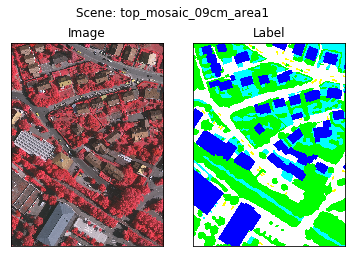

In [7]:
# import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# ignore annoying warnings
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(image, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Image')
fig.show()

ax = fig.add_subplot(122)
ax.imshow(label, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Label')

fig.suptitle('Scene: top_mosaic_09cm_area1')
fig.show()



Class labels are as follows <br>
0: Impervious surface (white)<br>
1: building (blue)<br>
2: low vegetation (cyan)<br>
3: tree (green)<br>
4: car (yellow)<br>

## Pre-processing
In order to apply deep learning methods, we need to do some pre-processing as follows.
* Cropping
* Normalization

## Cropping
Now, our training image (area1) has the size of $1919\times2569$. As you know, it is common that remote sensing imagery have such a large size. One problem is that deep learning methods cannnot be directly applied for such large images because the methods are usually memory consuming. It is often the case that one model requires several GB RAM memory to process patches of size $256\times256$. In order to apply deep learning to remote sensing imagery, we need to crop small patches from the large images. Here, we demonstrate how to do that.

### Crop single patch randomly
In the following, we randomly crop the training patches of size $256\times256$ from training images and labels. First, we demonstrate cropping of single patch from the original large images.

Set file path for the training images and the corresponding labels.

In [8]:
fpath_train_image1 = './dataset/isprs_vaihingen/train/image/top_mosaic_09cm_area21.tif'
fpath_train_image2 = './dataset/isprs_vaihingen/train/image/top_mosaic_09cm_area7.tif'
fpath_train_label1 = './dataset/isprs_vaihingen/train/label/top_mosaic_09cm_area21.tif'
fpath_train_label2 = './dataset/isprs_vaihingen/train/label/top_mosaic_09cm_area7.tif'

Import modules

In [9]:
import glob
import random
from PIL import Image
import numpy as np

Load training images and labels

In [10]:
image1 = np.array(Image.open(fpath_train_image1))
image2 = np.array(Image.open(fpath_train_image2))
label1 = np.array(Image.open(fpath_train_label1))
label2 = np.array(Image.open(fpath_train_label2))

Arrange image and label pair into list

In [11]:
list_data = [
    ['top_mosaic_09cm_area21', image1, label1],
    ['top_mosaic_09cm_area7' , image2, label2],
]

Randomly select a target scene from the list of training scene

In [12]:
name, image, label = random.choice(list_data)

Select crop position randomly

In [13]:
height, width, _ = image.shape
patch_size = 256
ulx = random.randrange(0, width - patch_size + 1)
uly = random.randrange(0, height - patch_size + 1)

Crop a patch pair

In [14]:
image_patch = image[uly:uly+patch_size, ulx:ulx+patch_size, :]
label_patch = label[uly:uly+patch_size, ulx:ulx+patch_size]

Now, we have cropped a patch pair of size $256\times256$. Let's check if the patches are correctly cropped by showing them.

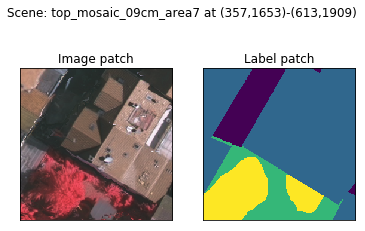

In [15]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(image_patch, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
fig.show()
ax.set_title('Image patch')

ax = fig.add_subplot(122)
ax.imshow(label_patch, interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Label patch')

fig.suptitle('Scene: %s at (%d,%d)-(%d,%d)' % (name, ulx, uly, ulx+patch_size, uly+patch_size))
fig.show()


Neural networks take as input the image patch on the left, and output corresponding classification result.
The goal of training is to optimize the network parameters so that the output of the network become close to the true label on the right.
In order to train networks that generalize to unseen images, we need variety of such training patch pairs so that the networks can learn variety of patterns. So, in the following, we crop multiple patches from the training scenes.

### Crop multiple patches randomly
 As stated above, here we crop multiple patches from the training scenes. Basically, we just apply the same procedure as above iteratively.

Settings for the cropping

In [16]:
num_patches = 750
patch_size = 256

Define place holders for containing cropped patches

In [17]:
list_image_patches = []
list_label_patches = []

Iterate the random cropping untile the defined number of patches are collected.

In [18]:
for i in range(num_patches):
    # choose scenes randomly
    name, image, label = random.choice(list_data)

    # choose crop position randomly
    height, width, _ = image.shape
    ulx = random.randrange(0, width - patch_size + 1)
    uly = random.randrange(0, height - patch_size + 1)

    # crop
    image_patch = image[uly:uly+patch_size, ulx:ulx+patch_size, :]
    label_patch = label[uly:uly+patch_size, ulx:ulx+patch_size]

    # contain
    list_image_patches.append(image_patch)
    list_label_patches.append(label_patch)


Convert place holder to ndarray

In [19]:
npy_image_patches = np.array(list_image_patches)
npy_label_patches = np.array(list_label_patches)

print(npy_image_patches.shape)
print(npy_label_patches.shape)

(750, 256, 256, 3)
(750, 256, 256)


Check the cropped patch pairs

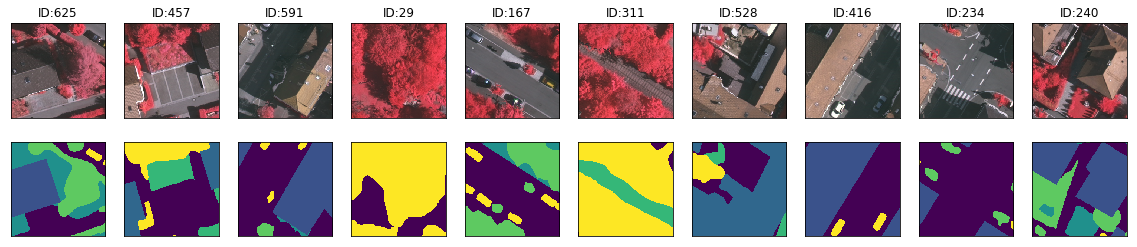

In [20]:
from matplotlib.gridspec import GridSpec
grid = GridSpec(nrows=2, ncols=10)

fig = plt.figure(figsize=(20,4))

for i in range(10):
    idx = random.randrange(len(npy_image_patches))
    image_patch = npy_image_patches[idx]
    label_patch = npy_label_patches[idx]
    
    ax = fig.add_subplot(grid[0,i])
    ax.imshow(image_patch, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('ID:%d' % idx)

    ax = fig.add_subplot(grid[1,i])
    ax.imshow(label_patch, interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
fig.show()


Finally, implement the cropping code as function so that we can reuse later.<br><br>
**Input**: 
- list of scenes (name, image, label)
- number of patches to crop
- size of the patches

**Output**: 
- cropped image patches (ndarray)
- cropped label patches (ndarray) 

In [21]:
def random_crop(list_data, num_patches, patch_size):
    list_image_patches = []
    list_label_patches = []

    for i in range(num_patches):
        # choose scenes randomly
        name, image, label = random.choice(list_data)

        # choose crop position randomly
        height, width, _ = image.shape
        ulx = random.randrange(0, width - patch_size + 1)
        uly = random.randrange(0, height - patch_size + 1)

        # crop
        image_patch = image[uly:uly+patch_size, ulx:ulx+patch_size, :]
        label_patch = label[uly:uly+patch_size, ulx:ulx+patch_size]

        # contain
        list_image_patches.append(image_patch)
        list_label_patches.append(label_patch)
    
    npy_image_patches =  np.array(list_image_patches)
    npy_label_patches =  np.array(list_label_patches)

    return npy_image_patches, npy_label_patches
    

## Normalization
Another pre-processing that is necessary is normalization of the cropped patches. Usually, the input images for neural networks are normalized. Simple but widely used methods is range adjustments. The methods adjust the range of pixel value to \[0,1\] or \[-1,1\]. For example, if we have a 8bit image, dividing each pixel value by 255 results in the pixel values of range \[0,1\]. For ground-based images, these methods are widely used. However, for remote sensing images, we recommend to normalize each band to have zero mean and unit variance. 

### Why we need normalization?
There are mainly two reasons.
1. **For fast training and good convergence**. The initialization of neural network parameters assumes normalized inputs. Therefore, without normalization, the initial parameter value will be far from optimal, which prolongs training time or even worse the training is not converge. 
2. **For robustness**. To normalize the influence of acquisition conditions (e.g. lighting conditions or sensors).

In the following, we demonstrate the normalization.

Calculate band-wise mean and std

In [22]:
mean1 = np.mean(image1, axis=(0,1), keepdims=True)
mean2 = np.mean(image2, axis=(0,1), keepdims=True)
std1 = np.std(image1, axis=(0,1), keepdims=True)
std2 = np.std(image2, axis=(0,1), keepdims=True)

Normalize original image

In [23]:
image1_normalized = (image1 - mean1) / std1
image2_normalized = (image2 - mean2) / std2

list_data_normalized = [
    ['top_mosaic_09cm_area21', image1_normalized, label1],
    ['top_mosaic_09cm_area7' , image2_normalized, label2],
]

Random crop using normalized images

In [24]:
npy_image_patches, npy_label_patches = random_crop(list_data_normalized, num_patches=750, patch_size=256)

Now, we have completed pre-processing for training data. Finally, let's save the cropped patches as numpy file.

In [25]:
#  Set output directory for cropped patches
import os
output_dir_train = './dataset/isprs_vaihingen/train/patches/'
if not os.path.isdir(output_dir_train):
    os.mkdir(output_dir_train)

Save patches as numpy file

In [26]:
np.save(output_dir_train + '/image.npy', npy_image_patches)
np.save(output_dir_train + '/label.npy', npy_label_patches)

### Pre-process validation patches
Pre-process validation patches in the same way as training patches

In [27]:
# set file path
fpath_val_image = './dataset/isprs_vaihingen/val/image/top_mosaic_09cm_area11.tif'
fpath_val_label = './dataset/isprs_vaihingen/val/label/top_mosaic_09cm_area11.tif'

# pre-load images and labels
image = np.array(Image.open(fpath_val_image))
label = np.array(Image.open(fpath_val_label))

# normalize
mean = np.mean(image1, axis=(0,1), keepdims=True)
std = np.std(image1, axis=(0,1), keepdims=True)
image_normalized = (image - mean) / std

# to list
list_data_normalized = [
    ['top_mosaic_09cm_area11', image_normalized, label],
]

# cropping
npy_image_patches, npy_label_patches = random_crop(list_data_normalized, num_patches=100, patch_size=256)

# save
output_dir_val = './dataset/isprs_vaihingen/val/patches/'
if not os.path.isdir(output_dir_val):
    os.mkdir(output_dir_val)
np.save(output_dir_val + '/image.npy', npy_image_patches)
np.save(output_dir_val + '/label.npy', npy_label_patches)

In [28]:
from PIL import Image
import numpy as np
import os

fpath_test_image = './dataset/isprs_vaihingen/test/image/top_mosaic_09cm_area30.tif'
fpath_test_label = './dataset/isprs_vaihingen/test/label/top_mosaic_09cm_area30.tif'
image = np.array(Image.open(fpath_test_image))
label = np.array(Image.open(fpath_test_label))

# Normalize
mean = np.mean(image, axis=(0,1), keepdims=True)
std = np.std(image, axis=(0,1), keepdims=True)
image = (image - mean) / std

patch_size = 256
stride = 256
height, width, _ = image.shape

num_tiles_x = (width - patch_size) // stride + 1
num_tiles_y = (height - patch_size) // stride + 1

list_image_patches = []
list_label_patches = []
for iy in range(num_tiles_y):
    for ix in range(num_tiles_x):
        ulx = ix * stride
        uly = iy * stride
        lrx = ulx + patch_size
        lry = uly + patch_size
            
        image_patch = image[uly:lry, ulx:lrx, :]
        label_patch = label[uly:lry, ulx:lrx]
        
        list_image_patches.append(image_patch)
        list_label_patches.append(label_patch)

npy_image_patches = np.array(list_image_patches)
npy_label_patches = np.array(list_label_patches)

# save
output_dir_test = './dataset/isprs_vaihingen/test/patches/'
if not os.path.isdir(output_dir_test):
    os.mkdir(output_dir_test)
np.save(output_dir_test + '/image.npy', npy_image_patches)
np.save(output_dir_test + '/label.npy', npy_label_patches)

print(npy_image_patches.shape)
print(npy_label_patches.shape)


(70, 256, 256, 3)
(70, 256, 256)
